In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

In [15]:
sys.path.append('./src')

from hinfinity_filter import HinfFilter as HINF
from utils import lla_to_enu, normalize_angles, generate_gt_sets, initial_pose_mat

## Import Data

In [17]:
base_dir = "./csv_dataset/"

gt_trajectory_xyz = np.loadtxt( base_dir + 'gt_trajectory_xyz.csv', delimiter=",", dtype=np.float32).T
obs_trajectory_xyz = np.loadtxt( base_dir + 'obs_trajectory_xyz.csv', delimiter=",", dtype=np.float32).T

gt_forward_velocities = np.loadtxt( base_dir + 'gt_forward_velocities.csv', delimiter=",", dtype=np.float32).T
obs_forward_velocities = np.loadtxt( base_dir + 'obs_forward_velocities.csv', delimiter=",", dtype=np.float32).T

gt_yaw_rates = np.loadtxt( base_dir + 'gt_yaw_rates.csv', delimiter=",", dtype=np.float32).T
obs_yaw_rates = np.loadtxt( base_dir + 'obs_yaw_rates.csv', delimiter=",", dtype=np.float32).T

gt_yaws = np.loadtxt( base_dir + 'gt_yaws.csv', delimiter=",", dtype=np.float32).T

ts = np.loadtxt( base_dir + 'ts.csv', delimiter=",", dtype=np.float32).T

## Initialize variables

In [4]:
N = gt_yaws.shape[0]
xy_obs_noise_std = 5.0
initial_yaw_std = np.pi
yaw_rate_noise_std = 0.02
forward_velocity_noise_std = 0.3

In [5]:
# initial state x_0
initial_yaw = gt_yaws[0] + np.random.normal(0, initial_yaw_std)

x = np.array([
    obs_trajectory_xyz[0, 0],
    obs_trajectory_xyz[1, 0],
    initial_yaw
])

In [6]:
# covariance for initial state estimation error (Sigma_0)

P = np.array([
    [xy_obs_noise_std ** 2., 0., 0.],
    [0., xy_obs_noise_std ** 2., 0.],
    [0., 0., initial_yaw_std ** 2.]
])

### Prepare measuerment error covariance Q

In [7]:
Q = np.array([
    [xy_obs_noise_std ** 2., 0.],
    [0., xy_obs_noise_std ** 2.]
])

### Prepare state transition noise covariance R

In [8]:
R = np.array([
    [forward_velocity_noise_std ** 2., 0., 0.],
    [0., forward_velocity_noise_std ** 2., 0.],
    [0., 0., yaw_rate_noise_std ** 2.]
])

### Prepare Filter routine

In [9]:
# initialize Kalman filter
hinf = HINF(x, P)

# array to store estimated 2d pose [x, y, theta]
hmu_x = [x[0],]
hmu_y = [x[1],]
hmu_theta = [x[2],]

# array to store estimated error variance of 2d pose
hvar_x = [P[0, 0],]
hvar_y = [P[1, 1],]
hvar_theta = [P[2, 2],]

t_last = 0.

### EKF Example

In [10]:
for t_idx in range(1, N):
    t = ts[t_idx]
    dt = t - t_last
    
    # get control input `u = [v, omega] + noise`
    u = np.array([
        obs_forward_velocities[t_idx],
        obs_yaw_rates[t_idx]
    ])
    
    # because velocity and yaw rate are multiplied with `dt` in state transition function,
    # its noise covariance must be multiplied with `dt**2.`
    R_ = R * (dt ** 2.)
    
    # propagate!
    hinf.propagate(u, dt, R)
    
    # get measurement `z = [x, y] + noise`
    z = np.array([
        obs_trajectory_xyz[0, t_idx],
        obs_trajectory_xyz[1, t_idx],
        0
    ])
    
    # update!
    hinf.update(z, Q, R)
    
    # save estimated state to analyze later
    hmu_x.append(hinf.x[0])
    hmu_y.append(hinf.x[1])
    hmu_theta.append(normalize_angles(hinf.x[2]))
    
    # save estimated variance to analyze later
    hvar_x.append(hinf.P[0, 0])
    hvar_y.append(hinf.P[1, 1])
    hvar_theta.append(hinf.P[2, 2])
    
    t_last = t
    

hmu_x = np.array(hmu_x)
hmu_y = np.array(hmu_y)
hmu_theta = np.array(hmu_theta)

hvar_x = np.array(hvar_x)
hvar_y = np.array(hvar_y)
hvar_theta = np.array(hvar_theta)

## Visualize estimated results

### trajectory

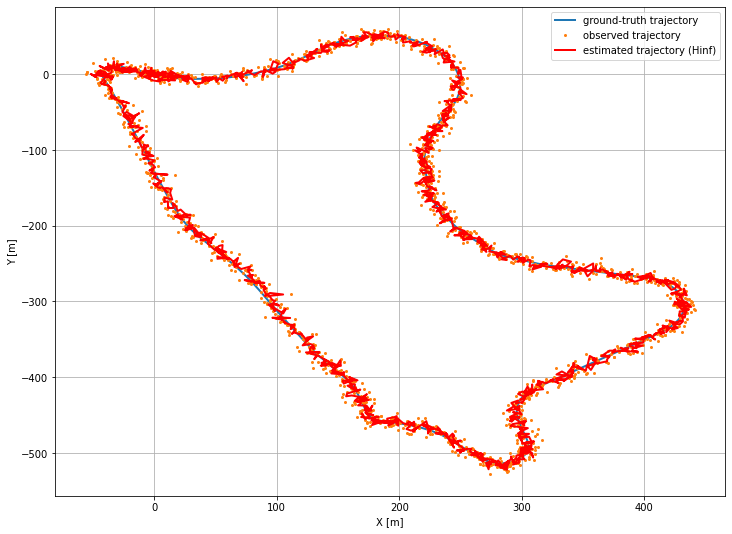

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(hmu_x, hmu_y, lw=2, label='estimated trajectory (Hinf)', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()